In [2]:
import os
import numpy as np
import pandas as pd

import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
import statsmodels.api as sm

from arch import arch_model

%matplotlib inline
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tools import *

In [3]:
symbol= 'SPY' # stock symbol
start_date = "2010-01-01"
end_date = "2022-12-31"
data_filename = f"data/{symbol}_{start_date}_{end_date}.csv"

if not os.path.exists(data_filename):
    data = yf.download(symbol, start=start_date, end=end_date)

    # if wanna model the more stationary 
    # percentage change of the Close price
    data['diffs']=np.around(data['Close'].pct_change()*100,8)
    data['diffs'].fillna(0,inplace=True)
    
    data['date']=data.index
    data['date'].dt.strftime('%Y-%m-%d')
    data=data.reset_index(drop=True)
    data.to_csv(data_filename, index=False)
else:
    data = pd.read_csv(data_filename, parse_dates=True)

In [4]:
seq_len = 20
label_len = 10
batchsize = 32
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_vali = len(data) - num_train - num_test
border1s = [0, num_train - seq_len, len(data) - num_test - seq_len]
border2s = [num_train, num_train + num_vali, len(data)]

# for actual data in use:
#len(train)=num_train-seq_len-4
#len(val)=(num_train + num_vali)-(num_train - seq_len)-seq_len-4=num_vali-4
#len(test)=len(data)-(len(data) - num_test - seq_len)-seq_len-4=num_test-4

# nominal datasets:
train_data = data[(border1s[0]<=data.index)&(data.index<border2s[1])]
# no valid dataset for arima model - 
# val_data = data[(border1s[1]<=data.index)&(data.index<border2s[1])]
test_data = data[(border1s[2]<=data.index)&(data.index<border2s[2])]

#  the index final 'test' dataset will plot : [(num_train + num_vali):(num_train + num_vali)+batchsize*((num_test-4)//batchsize)]
Ntest = batchsize*((num_test-4)//batchsize) # num of test data
test_plot_ind0 = (num_train + num_vali)
test_plot_ind1 = test_plot_ind0+Ntest
test_plot=test_data[(test_data.index>=test_plot_ind0)&(test_data.index<test_plot_ind1)]


# fit an ARIMA for the entire dataset 
this is to find the (smallest) order p and q needed for the ARIMA residual to be white noise 

pvalue= 0.8745564548233942
adf= -0.5840003888670464
critical_values= {'1%': -3.4323674112281393, '5%': -2.8624313714499374, '10%': -2.5672444962719756}


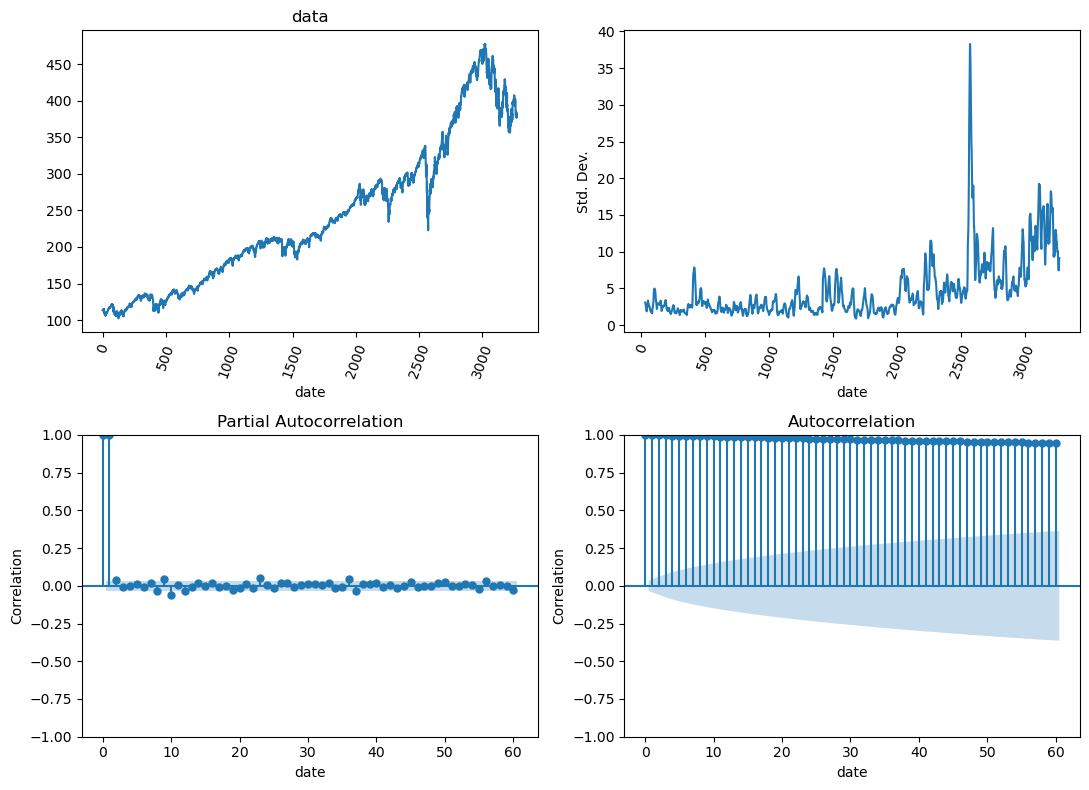

In [5]:
checkout_data(data['Close'])

It is not so stationary from the adf value > the 5% critical values and the look of the autocorrelation plot.

pvalue= 2.1180732927615648e-23
adf= -12.559484060077438
critical_values= {'1%': -3.4323667890369283, '5%': -2.862431096634527, '10%': -2.5672443499659305}


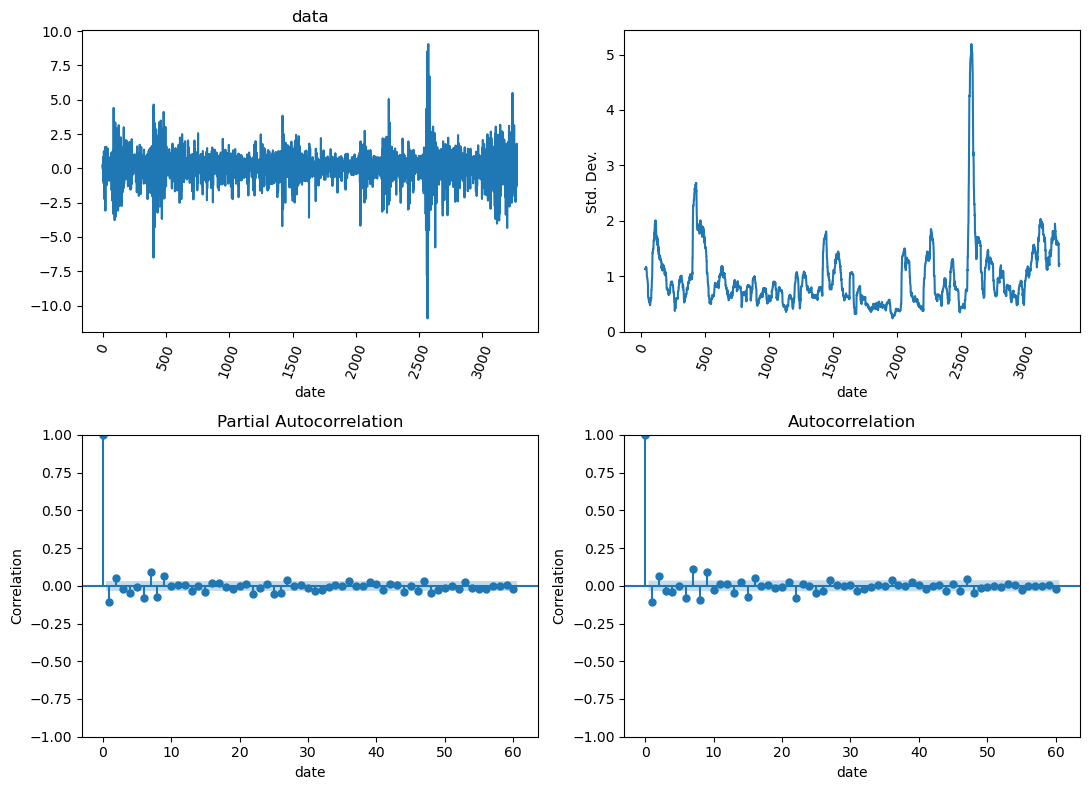

In [6]:
# this will be more stationary
checkout_data(data['diffs'])

p=9, q=22

In [7]:
# sm.tsa.stattools.arma_order_select_ic(train_data, ic=["aic", "bic"])
max_p=9
max_q=22
arima_fitted = pm.auto_arima(data['diffs'],
                             trace=True,
                             suppress_warnings=True,
                             d=0, start_p=3, start_q=4,
                             max_p=max_p, max_q=max_q,
                             max_order=max_p+max_q,
                             error_action ='ignore',
                             n_jobs=10, # num of models fitting at the same time
                             n_fits=max_p*max_q,
                             stepwise=True,seasonal=False)
arima_fitted.summary()

C:\Users\yc_ya\anaconda3\envs\mlFin\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=9884.285, Time=2.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9992.435, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9955.692, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9959.565, Time=0.05 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=9926.010, Time=1.92 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=9874.720, Time=2.09 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=9883.779, Time=1.77 sec
 ARIMA(5,0,4)(0,0,0)[0]             : AIC=9876.530, Time=2.12 sec
 ARIMA(4,0,5)(0,0,0)[0]             : AIC=9876.549, Time=2.25 sec
 ARIMA(3,0,5)(0,0,0)[0]             : AIC=9886.250, Time=0.90 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=9916.098, Time=2.36 sec
 ARIMA(5,0,5)(0,0,0)[0]             : AIC=9877.916, Time=2.44 sec
 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=9871.928, Time=3.62 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3272
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -4925.964
Date:                Tue, 09 Jan 2024   AIC                           9871.928
Time:                        10:59:23   BIC                           9932.860
Sample:                             0   HQIC                          9893.748
                               - 3272                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0620      0.029      2.119      0.034       0.005       0.119
ar.L1         -0.2369      0.035     -6.747      0.000      -0.306      -0.168
ar.L2          0.7971      0.039     20.207      0.000       0.720       0.874
ar.L3         -0.2659      0.041     -6.416      0.000      -0.347      -0.185
ar.L4         -0.8219      0.036    -22.763      0.000      -0.893      -0.751
ma.L1          0.1646      0.039      4.206      0.000       0.088       0.241
ma.L2         -0.7583      0.043    -17.757      0.000      -0.842      -0.675
ma.L3          0.2943      0.044      6.616      0.000       0.207       0.382
ma.L4          0.7144      0.040     17.922      0.000       0.636       0.793
sigma2         1.1867      0.015     80.682      0.000       1.158       1.216
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):              9323.11
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We need p=4 and q=4.

In [8]:
# analyse the residual from the arima model by Ljung-Box test
arima_resid = arima_fitted.arima_res_.resid

white_noise_arima = acorr_ljungbox(arima_resid, lags = [20], return_df=True)
white_noise_arima
# white_noise_arima.iloc[-1]['lb_pvalue']

,lb_stat,lb_pvalue
20,21.979452,0.341627


Since the p-value is >0.05, the residual can be regarded as white noise => We don't need to further model the noise using GARCH model

pvalue= 1.415079096261044e-24
adf= -13.143267102734844
critical_values= {'1%': -3.43236616722938, '5%': -2.8624308219885193, '10%': -2.567244203750082}


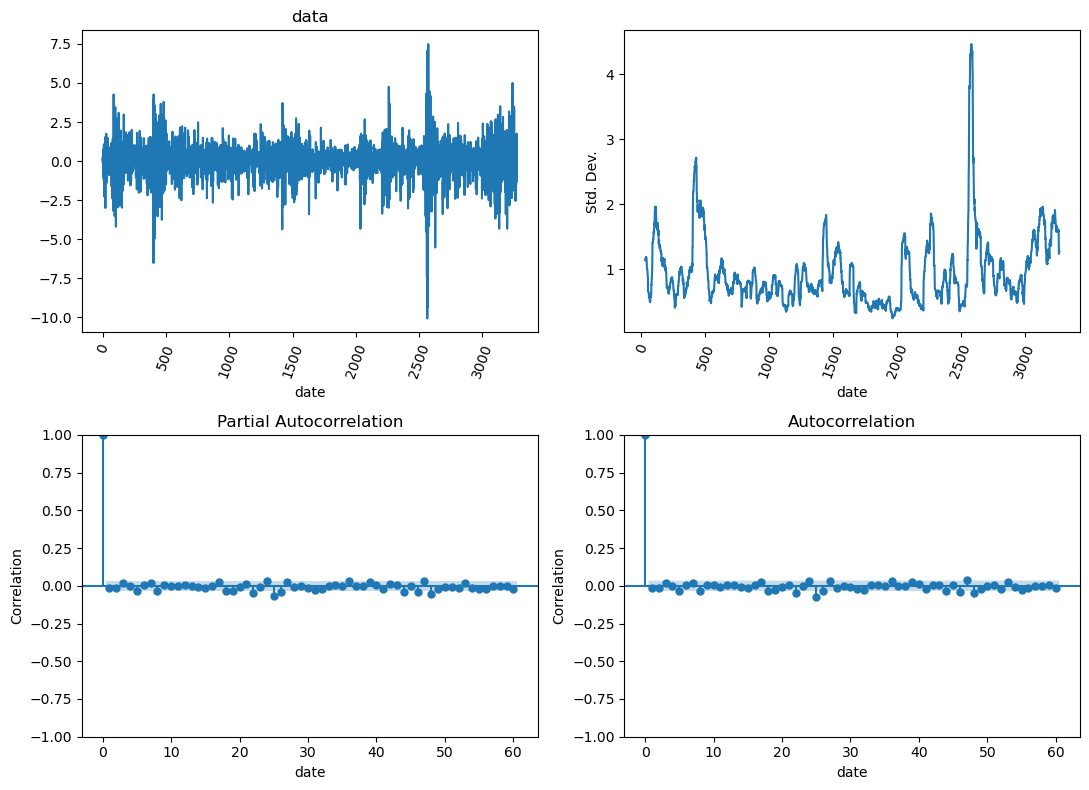

In [9]:
# checkout what the arima residual looks (for the GARCH model)
checkout_data(arima_resid)

# Rolling predictions of the ARIMA model

In [11]:
npz_name=f'{symbol}_diffs_{start_date}_{end_date}'
npz_path=f'arima_res/{npz_name}'

if not os.path.exists(npz_path+'.npz'):
    preds=[]
    for i in range(0,Ntest):
    
        if i%10==0:
            print('Now at i=',i)
        
        pred_ind = test_plot_ind0+i
    
        # as found above, we need p=4, q=4
        model_i = ARIMA(data[:pred_ind]['diffs'], order = (4, 0, 4))
        arima_res_i = model_i.fit()
        forecast_diff = arima_res_i.predict(start = pred_ind, end = pred_ind + 4)
        preds.append(forecast_diff.iloc[0])

    np.savez(npz_path,
         trues=test_plot,preds=preds,
         border1s=border1s,border2s=border2s,
         test_plot_ind0=test_plot_ind0,test_plot_ind1=test_plot_ind1)
else:
    pred_load=np.load(npz_path+'.npz',allow_pickle=True)
    preds=pred_load['preds']
    trues=pred_load['trues']
    

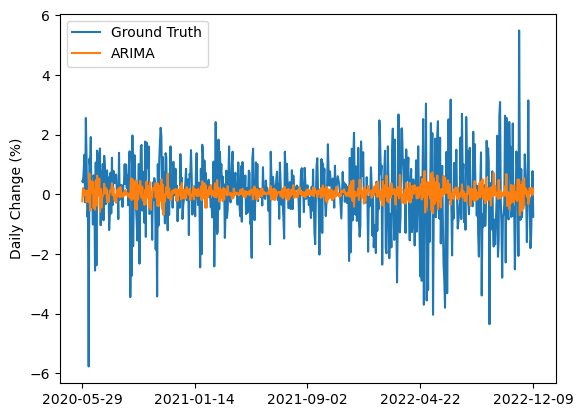

In [12]:
plt.plot(test_plot['diffs'].values,label='Ground Truth')
plt.plot(preds,label='ARIMA')
plt.ylabel('Daily Change (%)')
plt.xticks(ticks=np.linspace(0,Ntest-1,5,dtype=np.int32()),
           labels=[test_plot['date'].values[dd] for dd in np.linspace(0,Ntest-1,5,dtype=np.int32())])
plt.legend()
plt.show()

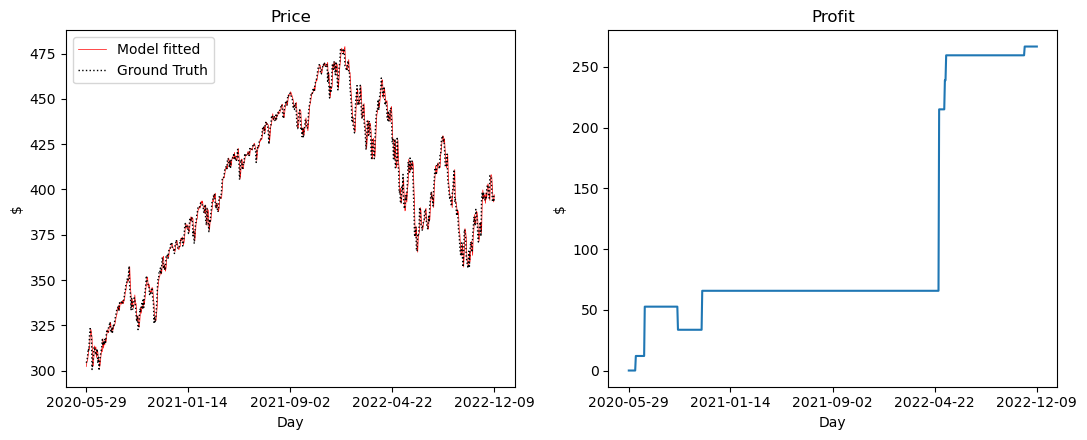

MSE: 23.11
mean return per sell: 0.0364
std of return per sell: 0.0495


In [18]:
simulate_pct_change(data[:(test_plot_ind0+Ntest)]['Close'].values,
                    preds,date_labels=test_plot['date'].values)